### 【 D0123_work_이준기 】

[ 2026-01-23] 과제

NYC Taxi Dataset

① 요금(Fare Amount) 회귀 예측  	 => MAE

② 장거리 Trip 분류 			 => F1

③ 공항 Trip 여부 분류 			 => F1

④ Trip Duration(이동 시간) 회귀 예측 => MAE

### 순서도 (계획)
1. 과제 번호 선택 (3번)
2. 데이터 확인 (컬럼 확인, 어떤 컬럼 사용할지 등)
3. 4개 데이터 전부 불러와서 전처리 진행
4. 공항 Trip 라벨 생성 (공항 좌표 정의)
5. Feature 선택 및 데이터셋 구성
6. 모델 설계 및 학습
7. 모델 평가
8. 결과 분석 및 해석
9. 결론 및 향후 개선 방향

In [16]:
## -------------------------------------------------------------------------------
## 모듈 로딩
## -------------------------------------------------------------------------------
import pandas as pd
import numpy as np

In [2]:
## -------------------------------------------------------------------------------
## 데이터 확인
## -------------------------------------------------------------------------------
DATA_FILE_TEST = '../D0123/Data/yellow_tripdata_2015-01.csv'

df_T = pd.read_csv(DATA_FILE_TEST)

df_T.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [3]:
df_T.shape

(12748986, 19)

- 총 컬럼 개수 19개
- 각 컬럼 의미 및 선택 여부
1. VendorID : 택시 회사 ID
2. tpep_pickup_datetime : 승차 시각
3. tpep_dropoff_datetime : 하차 시각
4. passenger_count : 승객 수
5. trip_distance : 이동 거리
6. pickup_longitude : 승차 경도
7. pickup_latitude : 승차 위도
8. RateCodeID : 요금 정책 코드
9. store_and_fwd_flag : 서버 전송 지연 여부
10. dropoff_longitude : 하차 경도
11. dropoff_latitude : 하차 위도
12. payment_type : 결제 방식
13. fare_amount : 기본 요금
14. extra : 추가 요금
15. mta_tax : 세금
16. tip_amount : 팁
17. tolls_amount : 톨게이트 요금
18. improvement_surcharge : 추가 요금
19. total_amount : 총 요금

- 사용할 컬럼
1. passenger_count : 승객 수
2. trip_distance : 이동 거리
3. pickup_longitude : 승차 경도
4. pickup_latitude : 승차 위도
5. dropoff_longitude : 하차 경도
6. dropoff_latitude : 하차 위도

-> 승차 시각과 하차 시각은 가공해서 탑승 시간으로 새로운 컬럼 생성 예정

In [33]:
## -------------------------------------------------------------------------------
## 전처리 함수 생성
## -------------------------------------------------------------------------------
def preprocessing(df):

    ## 선택 컬럼만 추출하기
    use_cols = [
    'passenger_count',
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
    ]
    df = df[use_cols]

    ## 결측치 제거
    df = df.dropna(subset=use_cols)

    ## 승객 수가 1보다 작거나 6보다 큰 이상치 제거
    cond1 = (df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)
    df = df[cond1]

    ## 이동 거리가 0인 이상치 제거
    cond2 = df['trip_distance'] > 0
    df = df[cond2]

    ## 뉴욕시 범위를 벗어난 승차 좌표값은 이상치로 판단하여 제거
    cond3 = (df['pickup_longitude'].between(-74.3, -73.6)) & (df['pickup_latitude'].between(40.5, 41.0))
    df = df[cond3]

    ## 뉴욕시 범위를 벗어난 하차 좌표값은 이상치로 판단하여 제거
    cond4 = (df['dropoff_longitude'].between(-74.3, -73.6)) & (df['dropoff_latitude'].between(40.5, 41.0))
    df = df[cond4]


    return df.reset_index(drop=True)

In [27]:
## -------------------------------------------------------------------------------
## 공항 반경 내인지 여부 라벨 생성하는 함수
## -------------------------------------------------------------------------------
def is_airport_trip(df):

    # 뉴욕시 공항들
    # John F. Kennedy Intl. Airport : JFK 
    # LaGuardia Airport             : LGA
    # Newark Liberty Intl. Airport  : EWR

    AIRPORTS  = {
        "JFK" : (40.6413, -73.7781),
        "LGA" : (40.7769, -73.8740),
        "EWR" : (40.6895, -74.1745)
    }

    AIRPORT_RADIUS = 3000   # 미터 단위


    ## ----------------------------------------------------------
    ## 위도, 경도를 미터 단위 거리로 변환하는 함수
    ## ----------------------------------------------------------
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371000 # 지구 반지름 (미터)

        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        dlat = lat2 - lat1
        dlon = lon2 - lon1
 
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        return R * c
    

    ## ----------------------------------------------------------
    ## 공항 반경 여부 판단
    ## ----------------------------------------------------------
    def check_airport(row):
        pi_lat, pi_lon = row['pickup_latitude'], row['pickup_longitude']
        dr_lat, dr_lon = row['dropoff_latitude'], row['dropoff_longitude']

        for lat, lon in AIRPORTS.values():
            if haversine(pi_lat, pi_lon, lat, lon) <= AIRPORT_RADIUS:
                return 1
            if haversine(dr_lat, dr_lon, lat, lon) <= AIRPORT_RADIUS:
                return 1
        return 0
    
    
    # 라벨 컬럼 생성
    df['is_airport_trip'] = df.apply(check_airport, axis=1)
    
    return df

In [20]:
df_Tc = df_T.copy()

In [ ]:
## ----------------------------------------------------------
## 전처리 적용 및 확인
## ----------------------------------------------------------
df_Tc = preprocessing(df_Tc)
df_Tc = is_airport_trip(df_Tc)
print(df_Tc.shape)
df_Tc.head()

(12426689, 7)


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,is_airport_trip
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,0
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,0
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,0
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,0
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,0


- 전처리 테스트 결과 12,748,986행 -> 12,426,689행.
- 322,297개의 이상치 행 정상적으로 삭제 확인 

In [ ]:
## ----------------------------------------------------------
## 비율 확인
## ----------------------------------------------------------
df_Tc['is_airport_trip'].value_counts(normalize=True)

is_airport_trip
0    0.942383
1    0.057617
Name: proportion, dtype: float64

< 실습 >

In [117]:
## ----------------------------------------------------------
## 모듈 로딩
## ----------------------------------------------------------
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from   torch.optim.lr_scheduler import ReduceLROnPlateau

from   torch.utils.data import Dataset, TensorDataset, DataLoader
from   torch.utils.data import random_split
from   sklearn.model_selection import train_test_split

import util_func as uf

import pandas as pd

In [32]:
## ----------------------------------------------------------
## 데이터 준비
## ----------------------------------------------------------
DATA_FILE1 = '../D0123/Data/yellow_tripdata_2015-01.csv'
DATA_FILE2 = '../D0123/Data/yellow_tripdata_2016-01.csv'
DATA_FILE3 = '../D0123/Data/yellow_tripdata_2016-02.csv'
DATA_FILE4 = '../D0123/Data/yellow_tripdata_2016-03.csv'

df1 = pd.read_csv(DATA_FILE1)
df2 = pd.read_csv(DATA_FILE2)
df3 = pd.read_csv(DATA_FILE3)
df4 = pd.read_csv(DATA_FILE4)

df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

df.shape

(47248845, 20)

In [34]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1.0,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,NaN
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1.0,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,NaN
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1.0,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,NaN
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1.0,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,NaN
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1.0,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,NaN


In [35]:
## ----------------------------------------------------------
## 전처리 적용 및 확인
## ----------------------------------------------------------
df = preprocessing(df)
df = is_airport_trip(df)
print(df.shape)
df.head()

(46206008, 7)


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,is_airport_trip
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,0
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,0
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,0
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,0
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,0


데이터 개수 : 46,206,008개

In [96]:
## ----------------------------------------------------------
## 데이터 샘플링 (학습 속도 개선)
## ----------------------------------------------------------
df_s = df.sample(n=3_000_000, random_state=42)

print(df_s.shape)

(3000000, 7)


In [97]:
## ----------------------------------------------------------
## 비율 확인
## ----------------------------------------------------------
df_s['is_airport_trip'].value_counts(normalize=True)

is_airport_trip
0    0.935417
1    0.064583
Name: proportion, dtype: float64

In [98]:
## ----------------------------------------------------------
## 데이터 나누기
## ----------------------------------------------------------
featureDF = df_s[df_s.columns[:-1]]
targetDF  = df_s[df_s.columns[-1:]]

In [99]:
## ----------------------------------------------------------
## 데이터셋 클래스 정의
## ----------------------------------------------------------
class TestDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.xTS = torch.tensor(featureDF.values, dtype=torch.float32)
        self.yTS = torch.tensor(targetDF.values, dtype=torch.float32) 
        self.length = featureDF.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.xTS[idx], self.yTS[idx]

In [100]:
## ----------------------------------------------------------
## 학습용/검증용/테스트용 데이터셋 분리
## ----------------------------------------------------------
x_train, x_test, y_train, y_test   = train_test_split(featureDF, targetDF,
                                                      test_size=0.2,
                                                      random_state=10)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                      test_size=0.2,
                                                      random_state=10)

In [101]:
## ----------------------------------------------------------
## 데이터셋 생성
## ----------------------------------------------------------
trainDS  = TestDataset(x_train, y_train)
validDS  = TestDataset(x_valid, y_valid)
testDS   = TestDataset(x_test, y_test)

print(len(trainDS), len(validDS), len(testDS))

1920000 480000 600000


In [102]:
## ----------------------------------------------------------
## 모델 클래스 정의
## ----------------------------------------------------------
class Test(nn.Module):
    def __init__(self, in_out, out_out):
        super().__init__()
        self.fc1 = nn.Linear(in_out, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, out_out)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.out(out)

학습 진행 <hr>

In [103]:
## 설정값들 
EPOCHS = 20
BS = 4096
LR = 0.1

## 저장 모델 파일명  => 
import os
os.makedirs("../Models", exist_ok=True)
ALL_MODEL     = '../Models/RegScore_model.pt'    ## 모델 전체 확장자    pt
WEIGHTS_MODEL = '../Models/RegScore_weights'     ## 파라미터 저장 확장자 pth

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [104]:
## ----------------------------------------------------------
## 인스턴스들
## ----------------------------------------------------------
from torchmetrics.classification import F1Score, Recall
model       = Test(in_out=x_train.shape[1], out_out=1).to(DEVICE)
loss_fn     = nn.BCEWithLogitsLoss()
optimizer   = optim.Adam(model.parameters(), lr= LR)

trainDL     = DataLoader(trainDS, batch_size=BS, shuffle=True)
validDL     = DataLoader(validDS, batch_size=BS) 
testDL      = DataLoader(testDS,  batch_size=BS)

## 스케쥴러 : 검증데이터의 성능지표에 대한 기준 loss, acc
scheduler   = ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [78]:
## 학습진행 =========================
f1_metric = F1Score(task="binary").to(DEVICE)

BEST_LOSS       = float("inf")  # 파이썬에서 표현 가능한 무한대 값
EARLY_STOP_CNT  = 10

for epoch in range(EPOCHS):

    # =======================
    # Train
    # =======================
    model.train()
    train_loss = 0.0
    f1_metric.reset()

    for x, y in trainDL:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        logits = model(x)              # (B, 1)
        loss   = loss_fn(logits, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        f1_metric.update(preds, y.int())

    train_loss /= len(trainDL.dataset)
    train_f1 = f1_metric.compute().item()


    # =======================
    # Validation
    # =======================
    model.eval()
    valid_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for x, y in validDL:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss   = loss_fn(logits, y)

            valid_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(logits) >= 0.5).int()
            f1_metric.update(preds, y.int())

    valid_loss /= len(validDL.dataset)
    valid_f1 = f1_metric.compute().item()


    # =======================
    # Scheduler & Save
    # =======================
    scheduler.step(valid_loss)

    if valid_loss < BEST_LOSS:
        BEST_LOSS = valid_loss
        torch.save(model, ALL_MODEL)
        torch.save(
            model.state_dict(),
            f"{WEIGHTS_MODEL}_{epoch:03}_{valid_loss:.5f}.pth"
        )

    # =======================
    # Log
    # =======================
    print(
        f"[{epoch:02d}] "
        f"LOSS train/valid = {train_loss:.5f} / {valid_loss:.5f} | "
        f"F1 train/valid = {train_f1:.4f} / {valid_f1:.4f} | "
        f"LR = {scheduler.get_last_lr()[0]:.6f}"
    )

    # =======================
    # Early Stop
    # =======================
    if scheduler.num_bad_epochs >= scheduler.patience:
        EARLY_STOP_CNT -= 1

    if EARLY_STOP_CNT == 0:
        print("성능 개선 없음 → 조기 종료")
        break


[00] LOSS train/valid = 0.28906 / 0.23979 | F1 train/valid = 0.0040 / 0.0000 | LR = 0.100000
[01] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[02] LOSS train/valid = 0.23981 / 0.23982 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[03] LOSS train/valid = 0.23981 / 0.23981 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.100000
[04] LOSS train/valid = 0.23982 / 0.23980 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[05] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[06] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[07] LOSS train/valid = 0.23980 / 0.23980 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.010000
[08] LOSS train/valid = 0.23980 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.001000
[09] LOSS train/valid = 0.23979 / 0.23979 | F1 train/valid = 0.0000 / 0.0000 | LR = 0.001000
[10] LOSS train/valid = 0.23979 / 0.23979 | F1 train/valid = 0.0000 / 

초기 학습에서는 클래스 불균형으로 인해 모든 샘플을 0으로 예측하는 현상이 발생

In [105]:
pos_weight = torch.tensor(
    [(len(df) - df['is_airport_trip'].sum()) / df['is_airport_trip'].sum()],
    device=DEVICE
)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.1
)

In [106]:
history = {
    "train_loss": [],
    "val_loss":   [],
    "train_f1":  [],   
    "val_f1":    []
}

In [108]:
## 학습진행 =========================
f1_metric = F1Score(task="binary").to(DEVICE)

BEST_F1         = 0.0
EARLY_STOP_CNT  = 5

for epoch in range(EPOCHS):

    # =======================
    # Train
    # =======================
    model.train()
    train_loss = 0.0
    f1_metric.reset()

    for x, y in trainDL:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        logits = model(x)              # (B, 1)
        loss   = loss_fn(logits, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).int()
        f1_metric.update(preds, y.int())

    train_loss /= len(trainDL.dataset)
    train_f1 = f1_metric.compute().item()


    # =======================
    # Validation
    # =======================
    model.eval()
    valid_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for x, y in validDL:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss   = loss_fn(logits, y)

            valid_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(logits) >= 0.5).int()
            f1_metric.update(preds, y.int())

    valid_loss /= len(validDL.dataset)
    valid_f1 = f1_metric.compute().item()


    # =======================
    # Save (F1 기준)
    # =======================
    if valid_f1 > BEST_F1:
        BEST_F1 = valid_f1
        torch.save(model, ALL_MODEL)
        torch.save(
            model.state_dict(),
            f"{WEIGHTS_MODEL}_{epoch:03}_F1_{valid_f1:.4f}.pth"
        )
        EARLY_STOP_CNT = 5
    else:
        EARLY_STOP_CNT -= 1


    # =======================
    # Log
    # =======================
    history["train_loss"].append(train_loss)   
    history["val_loss"].append(valid_loss)     
    history["train_f1"].append(train_f1)      
    history["val_f1"].append(valid_f1)        


    print(
        f"[{epoch+1:02d}] "
        f"LOSS train/valid = {train_loss:.5f} / {valid_loss:.5f} | "
        f"F1 train/valid = {train_f1:.4f} / {valid_f1:.4f}"
    )

    if EARLY_STOP_CNT == 0:
        print("F1 개선 없음 → 조기 종료")
        break


[01] LOSS train/valid = 0.38810 / 0.36774 | F1 train/valid = 0.6804 / 0.6879
[02] LOSS train/valid = 0.37631 / 0.36766 | F1 train/valid = 0.6849 / 0.7080
[03] LOSS train/valid = 0.37668 / 0.36931 | F1 train/valid = 0.6895 / 0.6709
[04] LOSS train/valid = 0.37591 / 0.36961 | F1 train/valid = 0.6908 / 0.6726
[05] LOSS train/valid = 0.37615 / 0.36550 | F1 train/valid = 0.6933 / 0.6882
[06] LOSS train/valid = 0.37533 / 0.36638 | F1 train/valid = 0.6958 / 0.6861
[07] LOSS train/valid = 0.37509 / 0.36482 | F1 train/valid = 0.6977 / 0.7082
[08] LOSS train/valid = 0.37441 / 0.38566 | F1 train/valid = 0.6992 / 0.7521
[09] LOSS train/valid = 0.37466 / 0.36936 | F1 train/valid = 0.7004 / 0.7345
[10] LOSS train/valid = 0.37486 / 0.36499 | F1 train/valid = 0.7007 / 0.7215
[11] LOSS train/valid = 0.37396 / 0.36838 | F1 train/valid = 0.7020 / 0.6767
[12] LOSS train/valid = 0.37428 / 0.37755 | F1 train/valid = 0.7025 / 0.6620
[13] LOSS train/valid = 0.37321 / 0.36333 | F1 train/valid = 0.7045 / 0.7093

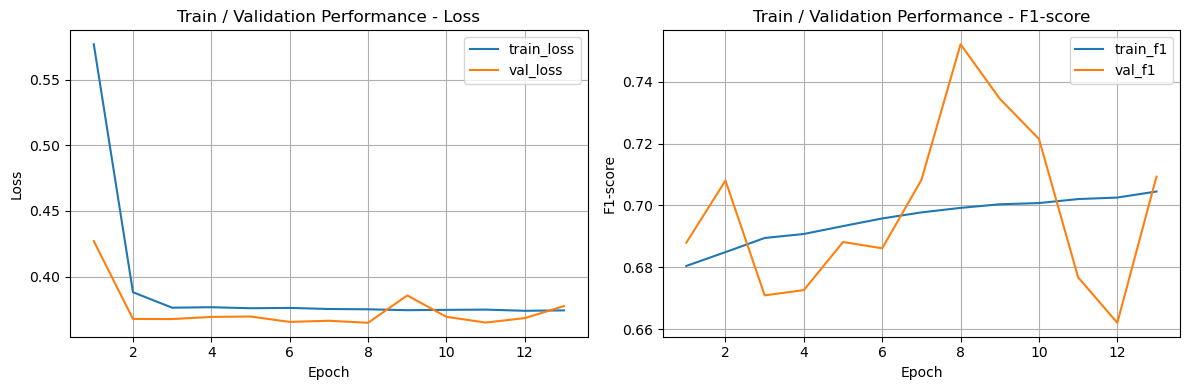

In [136]:
uf.plot_history(history, title="Train / Validation Performance")

클래스 불균형을 고려하여 pos_weight를 적용한 BCEWithLogitsLoss를 사용하였으며,
그 결과 검증 데이터 기준 F1-score 0.74 수준의 안정적인 분류 성능을 달성하였다.

1. 스케줄러를 사용하지 않은 이유
- learning rate scheduler를 적용할 경우, 학습 초반부터 학습률이 과도하게 감소하여 모델이 충분히 학습되지 못하는 현상을 관찰되었다. 특히, 클래스 뷸균형을 고려하여 pos_weight를 적용한 이후에는 고정된 learning rate 환경에서 F1-score가 더 안정적으로 증가하였다.

2. F1-score를 성능 지표로 사용한 이유
- 데이터에서 공항 Trip 여부의 비율이 약 6프로 수준으로 클래스 뷸균형이 매우 심한 이진 분류이다. 이 경우 단순 정확도는 다수 클래스에 편향된 결과를 보일 수 있으므로, Precision과 Recall을 동시에 고려하는 F1-score를 주요 성능 지표로 사용하였다.